# Compute Magnitudes Resolution from Flat SED in LSST filters

- author Sylvie Dagoret-Campagne
- affiliation IJCLab
- creation date : 2024/10/10


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename
dm_version = "w_2024_38"
path_rubinsimphot = f"repos/repos_{dm_version}/rubinsimphot/src"
#path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


In [4]:
def Get_SED_Pickles():
    seddir = os.path.join(fdir, 'pysynphot', 'pickles')
    seddir_uvi = os.path.join(seddir,"dat_uvi")
    seddir_uvk = os.path.join(seddir,"dat_uvk")
    all_pickles_uvi = sorted(os.listdir(seddir_uvi))
    all_pickles_uvk = sorted(os.listdir(seddir_uvk))
    file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")
    hdul = fits.open(file_ref)
    df_pickle = pd.DataFrame(hdul[1].data)
    NSED = len(df_pickle)

    for index in np.arange(NSED):
        filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
        fullfilename = os.path.join(seddir_uvk,filename) 
        hdul = fits.open(fullfilename)
        dff = pd.DataFrame(hdul[1].data)

In [5]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0

3630.7805477010033

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [6]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [7]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("LSST")

LSST site name validated as LSST observatory


In [8]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [9]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [10]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [13]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [14]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.0 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [15]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

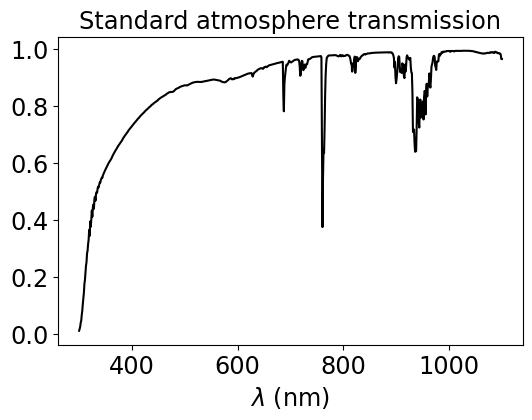

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

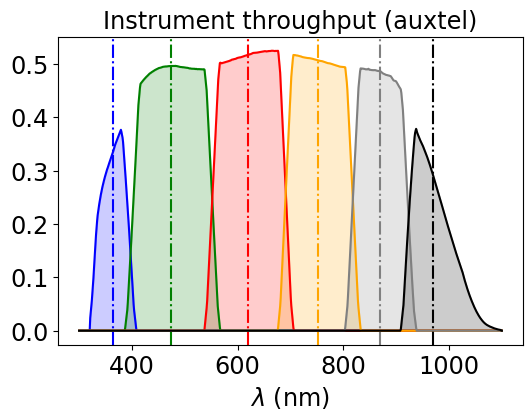

In [17]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

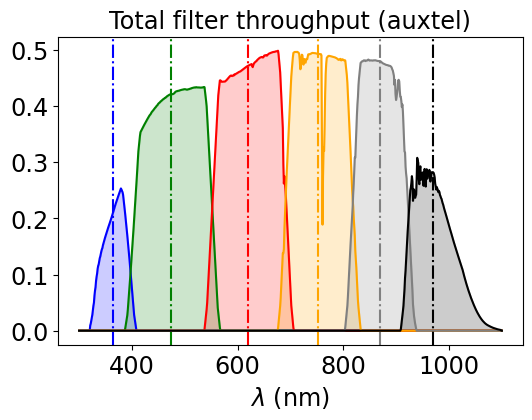

In [18]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Gaussian distribution of PWV

In [19]:
am = 1.2
oz = 300
tau= 0.0
beta = 1
pwv0 = 5.0
sigma_pwv = 1.
all_pwv = np.random.normal(pwv0, sigma_pwv, 100)
NPWV = len(all_pwv)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 3., 3., 2., 5., 2., 6., 4., 4., 5., 1., 8., 4., 6., 2., 2.,
        4., 5., 4., 5., 3., 2., 2., 1., 0., 3., 2., 1., 0., 2., 2., 2.]),
 array([1.41642743, 1.52919732, 1.6419672 , 1.75473709, 1.86750698,
        1.98027687, 2.09304676, 2.20581665, 2.31858654, 2.43135643,
        2.54412632, 2.65689621, 2.7696661 , 2.88243599, 2.99520588,
        3.10797577, 3.22074566, 3.33351555, 3.44628543, 3.55905532,
        3.67182521, 3.7845951 , 3.89736499, 4.01013488, 4.12290477,
        4.23567466, 4.34844455, 4.46121444, 4.57398433, 4.68675422,
        4.79952411, 4.912294  , 5.02506389, 5.13783377, 5.25060366,
        5.36337355, 5.47614344, 5.58891333, 5.70168322, 5.81445311,
        5.927223  , 6.03999289, 6.15276278, 6.26553267, 6.37830256,
        6.49107245, 6.60384234, 6.71661223, 6.82938212, 6.942152  ,
        7.05492189]),
 <BarContainer object of 50 artists>)

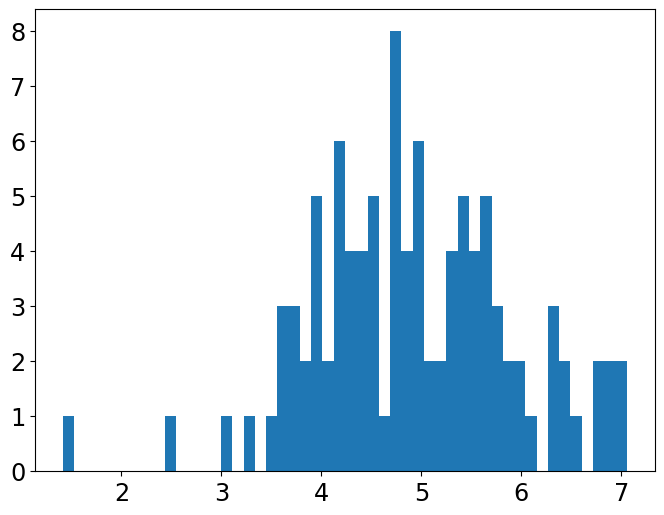

In [20]:
plt.hist(all_pwv,bins=50)

In [21]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

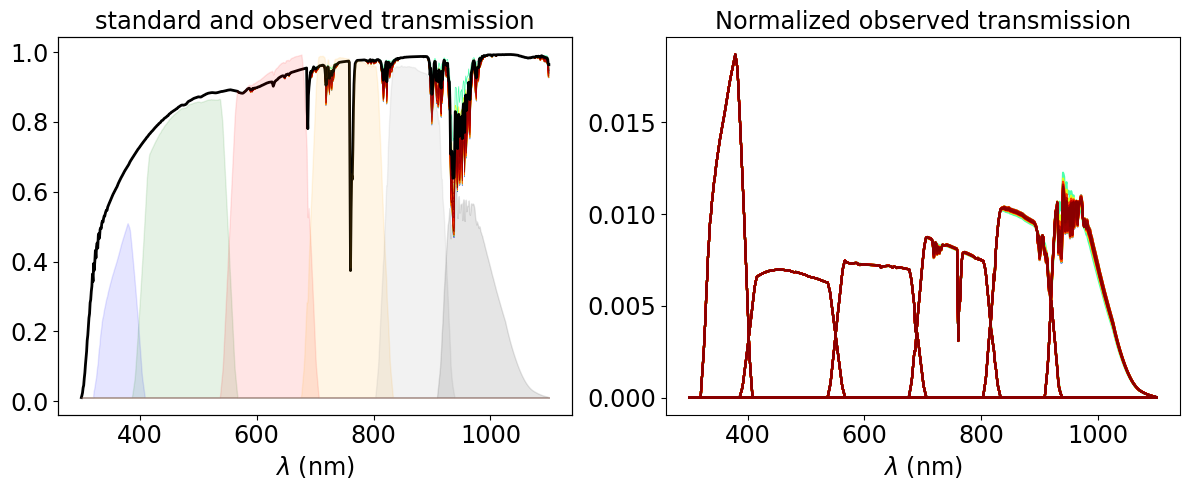

In [36]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,5))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



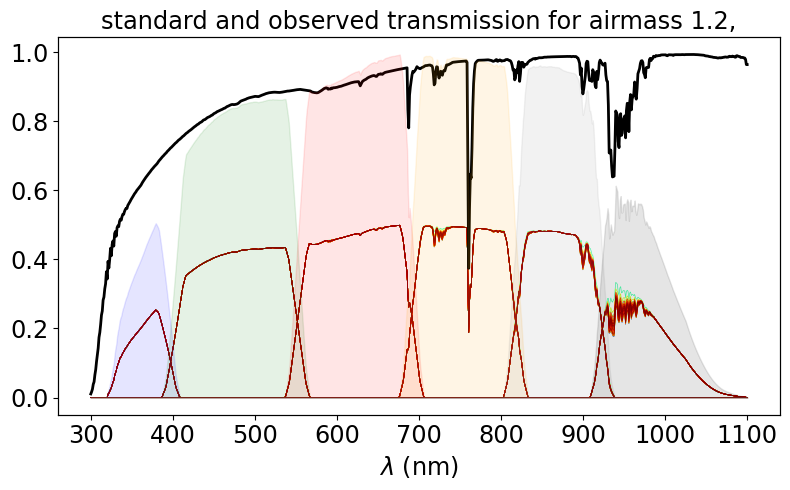

In [46]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(8,5))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):
    atm_bands = pc.coll_bandpass_total_nonstd[index]    
    label = f"pwv={pwv:.1f}" 
    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)

axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission for airmass 1.2,")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()


## SED

In [38]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [39]:
the_sed_flat = Sed()
the_sed_flat.set_flat_sed()
the_sed_flat.name = 'flat'
zmag = 20.0
flux_norm = the_sed_flat.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
the_sed_flat.multiply_flux_norm(flux_norm)

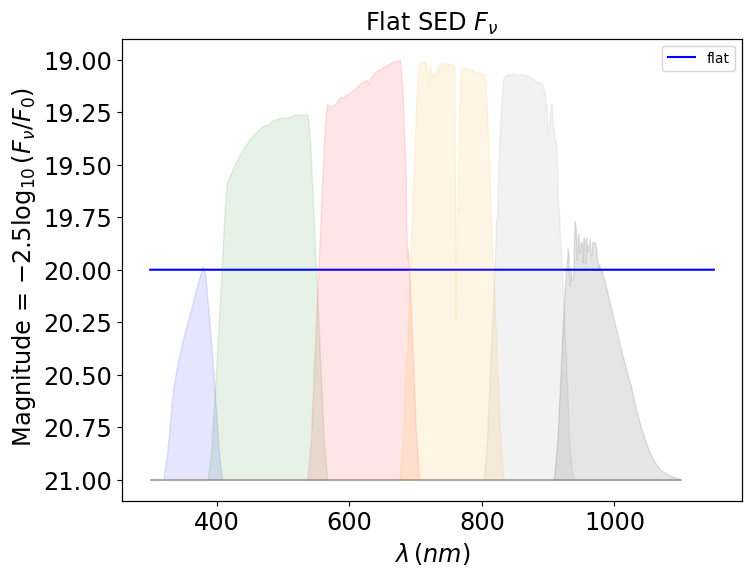

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(the_sed_flat .wavelen,-2.5*np.log10(the_sed_flat.fnu/F0),"b-",label=the_sed_flat.name)

ax.legend()
#ax.set_ylim(1e-17,1e-14)
#ax.set_xlim(300.,2000.)
ax.set_title("Flat SED $F_\\nu$")
ax.set_ylabel(" Magnitude = $-2.5 \log_{10}(F_\\nu/F_0)$")
ax.set_xlabel("$\\lambda \, (nm)$")
ax.yaxis.set_inverted(True)


ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])

In [40]:
the_sed = the_sed_flat

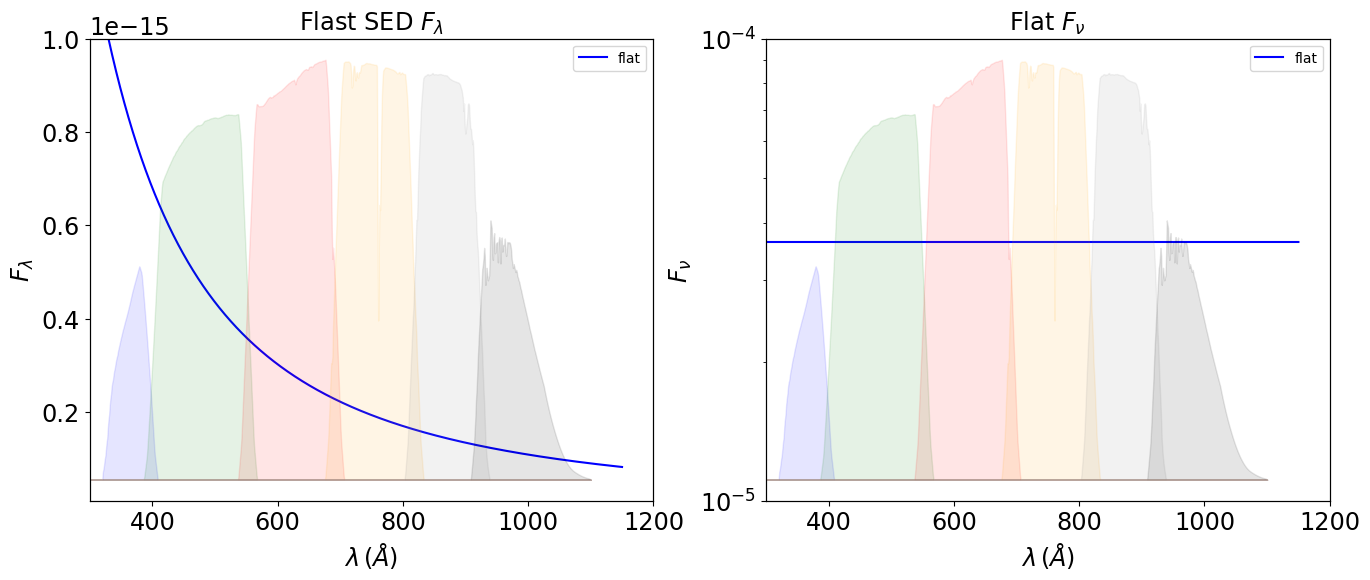

In [28]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,6))
ax.plot(the_sed .wavelen,the_sed .flambda,"b-",label=the_sed.name)
ax.legend()
ax.set_ylim(1e-17,1e-15)
ax.set_xlim(300.,1200.)
ax.set_title("Flast SED $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")


ax2.plot(the_sed .wavelen,the_sed.fnu,"b-",label=the_sed.name)

ax2.set_yscale("log")
ax2.legend()
ax2.set_ylim(1e-5,1e-4)
ax2.set_xlim(300.,1200.)
ax2.set_title("Flat $F_\\nu$")
ax2.set_ylabel("$F_\\nu$")
ax2.set_xlabel("$\lambda \, (\AA$)")

ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])
    
ax4 = ax2.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax4.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax4.set_yticks([])

## Calculate magnitudes

In [ ]:
for index,pwv in enumerate(all_pwv):
    atm_bands = pc.coll_bandpass_total_nonstd[index]    
    label = f"pwv={pwv:.1f}" 
    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)


In [48]:
df = pd.DataFrame(columns = ["pwv","magu","magg","magr","magi","magz","magy"])

for idx_pwv,pwv in enumerate(all_pwv):
    mags_nonstd = {}
    atm_bands = pc.coll_bandpass_total_nonstd[idx_pwv] 
    for index,f in enumerate(filter_tagnames) :
        mags_nonstd[f] = the_sed.calc_mag(atm_bands[f])-20.
    print(mags_nonstd)
    df.loc[idx_pwv] = [pwv, mags_nonstd["u"],mags_nonstd["g"],mags_nonstd["r"],mags_nonstd["i"],mags_nonstd["z"],mags_nonstd["y"]] 

{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r': 0.0, 'i': 0.0, 'z': 0.0, 'y': 0.0}
{'u': 0.0, 'g': 0.0, 'r'

<Axes: >

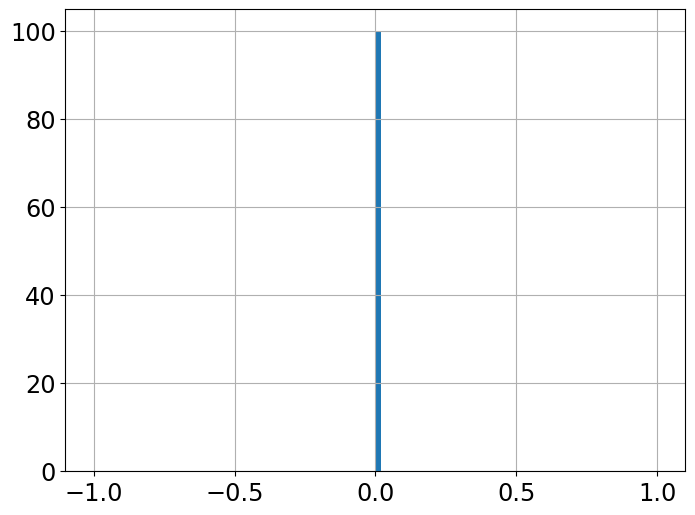

In [50]:
df["magy"].hist(bins=100,range=(-1,1))

In [ ]:
assert False

In [31]:
mags_std1 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std1[f] = the_sed1.calc_mag(pc.bandpass_total_std[f])
mags_std1["g-r"] = mags_std1["g"]- mags_std1["r"]  
mags_std1["z-y"] = mags_std1["z"]- mags_std1["y"]   
df1 = pd.DataFrame(mags_std1, index=[the_sed1.name]).T

mags_std2 = {}
for index,f in enumerate(filter_tagnames) :
    mags_std2[f] = the_sed2.calc_mag(pc.bandpass_total_std[f])
mags_std2["g-r"] = mags_std2["g"]- mags_std2["r"]  
mags_std2["z-y"] = mags_std2["z"]- mags_std2["y"]   
df2 = pd.DataFrame(mags_std2, index=[the_sed2.name]).T
dfa =pd.concat([df1,df2],axis=1)
dfa

NameError: name 'the_sed1' is not defined

In [ ]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_stdmag1 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag1[f] = -2.5*np.log10(the_sed1.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag1["g-r"] = adcs_stdmag1["g"]- adcs_stdmag1["r"]  
adcs_stdmag1["z-y"] = adcs_stdmag1["z"]- adcs_stdmag1["y"]      
df1 = pd.DataFrame(adcs_stdmag1, index=[the_sed1.name]).T

adcs_stdmag2 = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag2[f] = -2.5*np.log10(the_sed2.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag2["g-r"] = adcs_stdmag2["g"]- adcs_stdmag2["r"]  
adcs_stdmag2["z-y"] = adcs_stdmag2["z"]- adcs_stdmag2["y"]      
df2 = pd.DataFrame(adcs_stdmag2, index=[the_sed2.name]).T

dfb =pd.concat([df1,df2],axis=1)
dfb

## Generate dataframe with magnitudes

In [ ]:
filter_tagnames

In [ ]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)

In [ ]:
df_out = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                 "aduu","adug","adur","adui","aduz","aduy"])
mags_std = {}
adcs_stdmag = {}
for index in np.arange(NSED):
    spectype = df_pickle.loc[index,"SPTYPE"].strip()
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    the_sed = all_sed[index] 
    for index2,f in enumerate(filter_tagnames) :
        mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
    df_out.loc[index] = [ index,filename, spectype ,
                    mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                    adcs_stdmag["u"],adcs_stdmag["g"],adcs_stdmag["r"],adcs_stdmag["i"],adcs_stdmag["z"],adcs_stdmag["y"]]
                                

In [ ]:
mags_std

In [ ]:
df_out = df_out[df_out.index != 104]

In [ ]:
df_out["magG_R"] = df_out["magg"] - df_out["magr"]
df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
df_out["aduG_R"] = df_out["adug"] - df_out["adur"]
df_out["aduZ_Y"] = df_out["aduz"] - df_out["aduy"]

In [ ]:
df_out.head() 

In [ ]:
df_out.spectype.values

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="o",c="index",colormap="jet",ax=ax,grid=True,colorbar=False)
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (obs ADU mag) of Pickles stars")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="o",c="index",colormap="jet",ax=ax,grid=True,colorbar=False)

#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels):
    the_label = int(labels[ilab])
    labels[ilab] = df_out.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (calib AB mag) for Pickles stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
df_out.plot.scatter(x="index",y="magG_R",ax=ax1,grid=True,c="b")
df_out.plot.scatter(x="index",y="magZ_Y",ax=ax2,grid=True,c="r")

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

ax1.locator_params(axis='x', nbins=2*len(labels1)) 
ax2.locator_params(axis='x', nbins=2*len(labels2)) 

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

Nlabels1 = len(labels1)
for ilab in range(1,Nlabels1-1):
    the_label = int(labels1[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels1[ilab] = df_out.loc[the_label,"spectype"]
ax1.set_xticklabels(labels1,rotation=90)
ax1.set_xlabel(None)


Nlabels2 = len(labels2)
for ilab in range(1,Nlabels2-1):
    the_label = int(labels2[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels2[ilab] = df_out.loc[the_label,"spectype"]
ax2.set_xticklabels(labels2,rotation=90)
ax2.set_xlabel(None)

ax1.set_title("Pickles stars colors (calib AB mag)")

plt.tight_layout()